<center><h1>Domain Adaptation</h1></center>

<center><h2><a href="https://arthurdouillard.com/deepcourse/">Course link</a></h2></center>

To keep your modifications in case you want to come back later to this colab, do *File -> Save a copy in Drive*.

We will implement the paper **Unsupervised Domain Adaptation by Backpropagation** in this session. We strongly advise to read this paper, it's a major one!

https://arxiv.org/abs/1409.7495

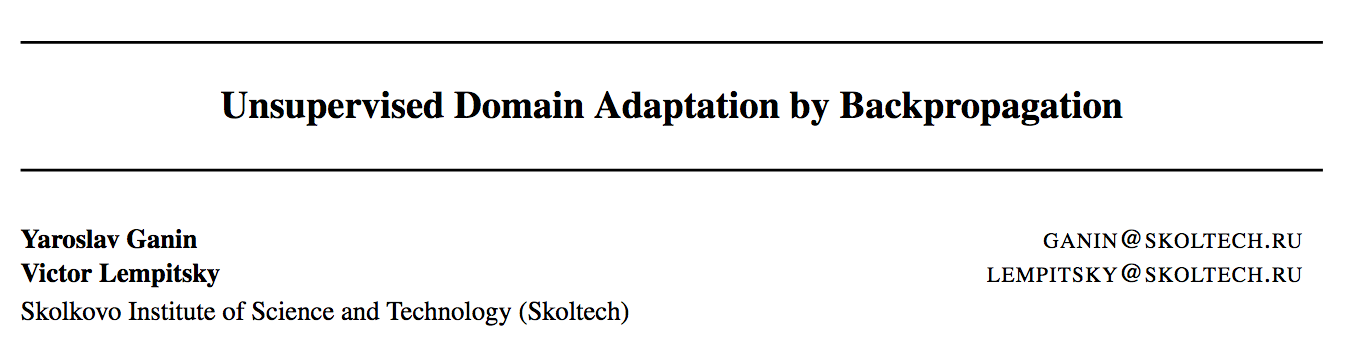

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:

import pickle
import math

import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms
import torchvision
from PIL import Image

We are going to do a **domain adaptation** from a source dataset (MNIST) towards a target dataset (MNIST-M).

First, we need to create the target dataset:

In [3]:
!wget https://raw.githubusercontent.com/rdfia/rdfia.github.io/master/code/3-c/mnistm.py

--2023-12-29 19:21:04--  https://raw.githubusercontent.com/rdfia/rdfia.github.io/master/code/3-c/mnistm.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2821 (2.8K) [text/plain]
Saving to: ‘mnistm.py’

mnistm.py           100%[===================>]   2.75K  --.-KB/s    in 0s      

2023-12-29 19:21:04 (41.6 MB/s) - ‘mnistm.py’ saved [2821/2821]



In [4]:
from urllib.request import urlretrieve

# Remplacez ceci avec la nouvelle URL fournie qui fonctionne
urlretrieve("http://www2.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/BSR/BSR_bsds500.tgz", "BSR_bsds500.tgz")


('BSR_bsds500.tgz', <http.client.HTTPMessage at 0x7d4aa11207f0>)

In [5]:
from mnistm import create_mnistm

create_mnistm()

Creating MNIST-M... That may takes a minute
Loading BSR training images


100%|██████████| 9912422/9912422 [00:00<00:00, 134568824.73it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 109229660.80it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 138792498.28it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 5488484.23it/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



/content/mnistm.py:45: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  bg_img = rand.choice(background_data)


Building train set...
Processing example 0
Processing example 10000
Processing example 20000
Processing example 30000
Processing example 40000
Processing example 50000
Building test set...
Processing example 0
Done!


Then, let's load the MNIST dataset and compute its (train!) mean and standard deviation.

We will use those values to **standardize** both MNIST and MNIST-M.

In [6]:
mnist_pixels = torchvision.datasets.MNIST('.', train=True, download=True).data / 255
mean = mnist_pixels.mean().item()
std = mnist_pixels.std().item()

print(f"Mean {mean} and Std {std}")
mean = torch.tensor([mean, mean, mean])
std = torch.tensor([std, std, std])

Mean 0.13066047430038452 and Std 0.30810782313346863


Create the loaders for MNIST...

In [7]:
transform = transforms.Compose([
  transforms.ToTensor(),
  lambda x: x.repeat(3, 1, 1) if x.shape[0] == 1 else x,
  transforms.Normalize(mean, std)
])

mnist_train = torchvision.datasets.MNIST('.', train=True, transform=transform)
mnist_test = torchvision.datasets.MNIST('.', train=False, transform=transform)

source_train_loader = DataLoader(mnist_train, batch_size=128)
source_test_loader = DataLoader(mnist_test, batch_size=128)

... and visualize!

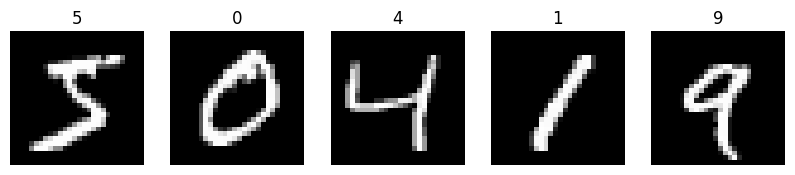

In [8]:
plt.figure(figsize=(10, 7))

for i in range(5):
  ax = plt.subplot(1, 5, i + 1)
  ax.axis('off')

  x, y = mnist_train[i]
  img = ((x * std[:, None, None] + mean[:, None, None]) * 255).permute(1, 2, 0)
  plt.imshow(img.numpy().astype(np.uint8), cmap='gray')
  plt.title(y)

Likewise, for MNIST-M. We create a simple `Dataset` in order to load the dataset that was serialized as a pickle:

In [9]:
with open('mnistm_data.pkl', 'rb') as f:
  mnist_m = pickle.load(f)

class MNISTM(torch.utils.data.Dataset):
  def __init__(self, x, y, transform):
    self.x, self.y = x, y
    self.transform = transform

  def __len__(self):
    return len(self.x)

  def __getitem__(self, index):
    x, y = self.x[index], self.y[index]
    x = self.transform(x)

    return x, y

mnistm_train = MNISTM(mnist_m["x_train"], mnist_m["y_train"], transform)
mnistm_test = MNISTM(mnist_m["x_test"], mnist_m["y_test"], transform)

target_train_loader = DataLoader(mnistm_train, batch_size=128)
target_test_loader = DataLoader(mnistm_test, batch_size=128)

And we also visualize it. Remember to always visualize your data before training a model on it. You may realize that the dataset is ill-formated, in its pixels or targets, and have to do more data preparation beforehand.

Noice that **MNIST-M** is extremely similar to MNIST. The only difference is that the former has colors and textures, and is thus a RGB image. Because MNIST is in grayscale, we have duplicated thrice its channels axis.

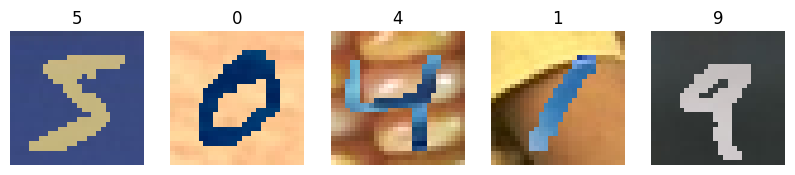

In [10]:
plt.figure(figsize=(10, 7))

for i in range(5):
  ax = plt.subplot(1, 5, i + 1)
  ax.axis('off')

  x, y = mnistm_train[i]
  img = ((x * std[:, None, None] + mean[:, None, None]) * 255).permute(1, 2, 0)
  plt.imshow(img.numpy().astype(np.uint8))
  plt.title(y)

Now, let's implement this basic network, whose figure is extracted from the paper. Conceive your model so that convolutions do not reduce the spatial dimensions:

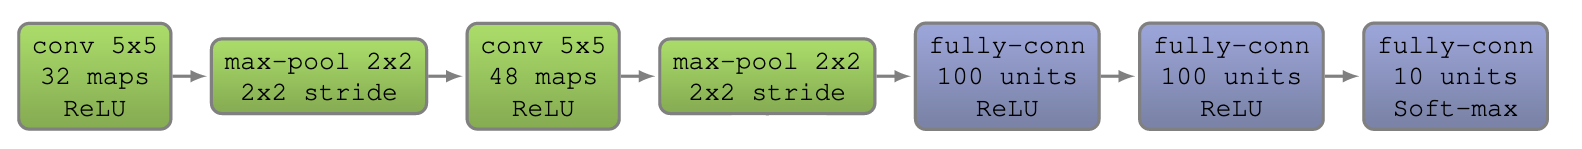

In [11]:
class NaiveNet(nn.Module):
  def __init__(self):
    super().__init__()  # Important, otherwise will throw an error

    self.cnn = nn.Sequential(
            nn.Conv2d(3, 32, (5, 5), stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0),
            nn.Conv2d(32, 48, (5, 5), stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0),
        )

    self.classif = nn.Sequential(
            nn.Linear(2352, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100,10)
            # Reminder: The softmax is included in the loss, do not put it here
        )

  def forward(self, x):
      bsize = x.size(0) # batch size
      output = self.cnn(x) # output of the conv layers
      output = output.view(bsize, -1) # we flatten the 2D feature maps into one 1D vector for each input
      output = self.classif(output) # we compute the output of the fc layers
      return output

NaiveNet()(torch.randn(2, 3, 28, 28)).shape

torch.Size([2, 10])

In [12]:
def eval_model(net, loader):
  net.eval()

  acc, loss = 0, 0.
  c = 0
  for x, y in loader:
    c += len(x)

    with torch.no_grad():
      logits = net(x.cuda()).cpu()

    loss += F.cross_entropy(logits, y).item()
    acc += (logits.argmax(dim=1) == y).sum().item()

  return round(100 * acc / c, 2), round(loss / len(loader), 5)

Let's train our naive model, but only the source (MNIST) dataset. We will evaluate its performance on the target (MNIST-M) dataset afterwards.

Notice that we use a **learning rate scheduler**. We are updating the learning rate after each epoch according to a function defined with a *lambda* following the paper specification.

We set the initial learning rate to 1.0 because `LambdaLR` defines a *multiplicative factor* of the base learning rate.

It's often useful to reduce likewise the learning rate during training, to facilitate convergence once the model has found a good local minima (we rarely find the global).

In [13]:
epochs = 10

naive_net = NaiveNet().cuda()

optimizer = torch.optim.SGD(naive_net.parameters(), lr=1.0, momentum=0.9)

mu0, alpha, beta = 0.01, 10, 0.75
scheduler = torch.optim.lr_scheduler.LambdaLR(
    optimizer,
    lambda e: 0.01 / (1 + alpha * e / epochs) ** beta
)

for epoch in range(epochs):
  train_loss = 0.

  for x, y in source_train_loader:
    x, y = x.cuda(), y.cuda()

    optimizer.zero_grad()
    logits = naive_net(x)
    loss = F.cross_entropy(logits, y)
    loss.backward()
    optimizer.step()

    train_loss += loss.item()
  print(f'Epoch {epoch}, train loss: {round(train_loss / len(source_train_loader), 5)}')
  scheduler.step()
  print(f"\tLearning rate = {optimizer.param_groups[0]['lr']}")

test_acc, test_loss = eval_model(naive_net, source_test_loader)
print(f"Test loss: {test_loss}, test acc: {test_acc}")

Epoch 0, train loss: 0.3859
	Learning rate = 0.005946035575013606
Epoch 1, train loss: 0.05763
	Learning rate = 0.004386913376508308
Epoch 2, train loss: 0.03903
	Learning rate = 0.0035355339059327372
Epoch 3, train loss: 0.03081
	Learning rate = 0.002990697562442441
Epoch 4, train loss: 0.02591
	Learning rate = 0.0026084743001221454
Epoch 5, train loss: 0.02249
	Learning rate = 0.002323680802425408
Epoch 6, train loss: 0.01992
	Learning rate = 0.0021022410381342864
Epoch 7, train loss: 0.01788
	Learning rate = 0.0019245008972987524
Epoch 8, train loss: 0.01619
	Learning rate = 0.0017782794100389228
Epoch 9, train loss: 0.01477
	Learning rate = 0.0016556002607617019
Test loss: 0.02592, test acc: 99.16


Performance onn less than 10 epochs are great on MNIST, more than 99% accuracy! But this dataset is quite easy.

Now, the real question is: can our model generalize on the slightly different domain of MNIST-M?

In [14]:
test_acc, test_loss = eval_model(naive_net, target_test_loader)
print(f"Test loss: {test_loss}, test acc: {test_acc}")

Test loss: 1.51877, test acc: 54.07


No... You should have an accuracy of 53 to 57%, far less than the 99% we had.

We are going to implement **DANN**, the **Domain Adverserial Neural Network**. The key part of this network is its domain prediction branch and its **gradient reversal layer** (GRL).

The GRL will reverse the gradient between the domain classifier (in pink) and the features extractor (in green).

What does it mean intuitively? The gradient of the domain classifier should help to better classify the domain. Therefore if we reverse it before the end of the features extractor, we will force this CNN to do the opposite: to make the features as agnostic as possible from the domain. Which would mean that the features of MNIST and MNIST-M will be similar and only the digit info will be kept.

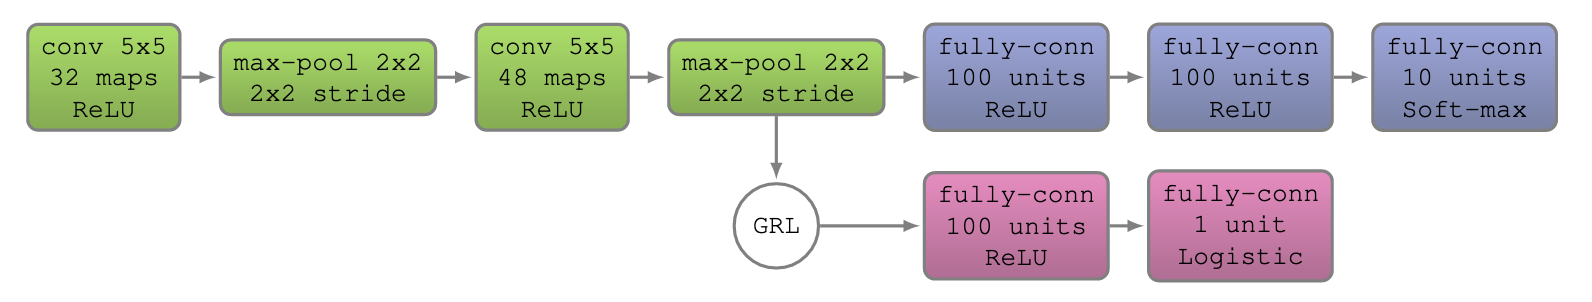

To code a custom backward in PyTorch, you need to define a `torch.autograd.Function`.

The forward is easy, we do nothing except storing a factor that we will need in the backward pass.

In the backward pass we need to return as much gradients as there are inputs (here two). Because the factor is not something to be optimized, we return `None`.

Now, given the factor (which is defaulted to -1, aka "reverse"), define the modified gradient:



In [15]:
class GradientReversal(torch.autograd.Function):
  @staticmethod
  def forward(ctx, x, factor=-1):
    ctx.save_for_backward(torch.tensor(factor))
    return x

  @staticmethod
  def backward(ctx, grad):
    factor, = ctx.saved_tensors

    reversed_grad = grad*factor

    return reversed_grad, None

In [16]:
x = torch.tensor([42.], requires_grad=True)
y = torch.tensor([1337.], requires_grad=True)
o = x * y
o.backward()
print(x.grad.item())

x = torch.tensor([42.], requires_grad=True)
y = torch.tensor([1337.], requires_grad=True)
o = GradientReversal.apply(x * y, -1)
o.backward()
print(x.grad.item())

1337.0
-1337.0


To use a PyTorch's `Function`, call its apply

Now, code the DANN. You can re-use parts of the code you wrote for the naive model.

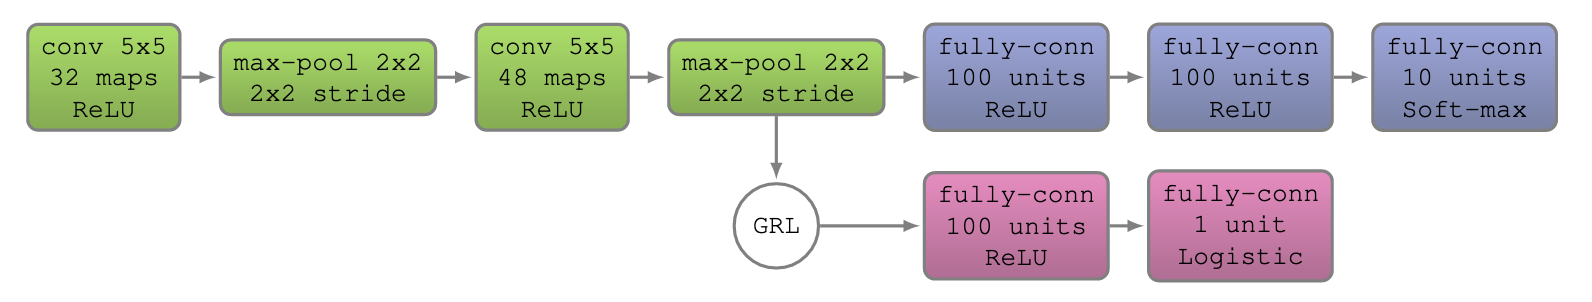

In [17]:
class DANN(nn.Module):
  def __init__(self):
    super().__init__()  # Important, otherwise will throw an error

    self.cnn = nn.Sequential(
            nn.Conv2d(3, 32, (5, 5), stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0),
            nn.Conv2d(32, 48, (5, 5), stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0),
        )

    self.classif = nn.Sequential(
            nn.Linear(2352, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100,10)
        )

    self.domain = nn.Sequential(
            nn.Linear(2352, 100),
            nn.ReLU(),
            nn.Linear(100, 1),
            nn.Sigmoid()
        )

  def forward(self, x, factor=1):
    bsize = x.size(0) # batch size
    output = self.cnn(x) # output of the conv layers
    output = output.view(bsize, -1) # we flatten the 2D feature maps into one 1D vector for each input

    class_pred = self.classif(output) # we compute the output of the fc layers

    rev_output = GradientReversal.apply(output, -factor)
    domain_pred= self.domain(rev_output)


    return class_pred, domain_pred


In [18]:
def eval_dann(net, loader, source=True):
  net.eval()

  c_acc, d_acc, cls_loss, d_loss = 0, 0, 0., 0.
  c = 0
  for x, y in loader:
    x = x.cuda()
    if source:
      d = torch.ones(len(x))
    else:
      d = torch.zeros(len(x))

    c += len(x)

    with torch.no_grad():
      cls_logits, domain_logits = net(x.cuda())
      cls_logits, domain_logits = cls_logits.cpu(), domain_logits.cpu()

    cls_loss += F.cross_entropy(cls_logits, y).item()
    d_loss += F.binary_cross_entropy_with_logits(domain_logits[:, 0], d).item()

    c_acc += (cls_logits.argmax(dim=1) == y).sum().item()
    d_acc += ((torch.sigmoid(domain_logits[:, 0]) > 0.5).float() == d).sum().item()

  return round(100 * c_acc / c, 2), round(100 * d_acc / c, 2), round(cls_loss / len(loader), 5), round(d_loss / len(loader), 5)

In [19]:
source_train_loader = DataLoader(mnist_train, batch_size=64)
target_train_loader = DataLoader(mnistm_train, batch_size=64)

len(source_train_loader), len(target_train_loader)

(938, 938)

For the GRL, using directly a factor -1 will results in very bad performance. Therefore we are going to grow the factor gradually during training (deep learning is an art!).

Here is a plot of the function we will use (note that it is a modified version from the paper):

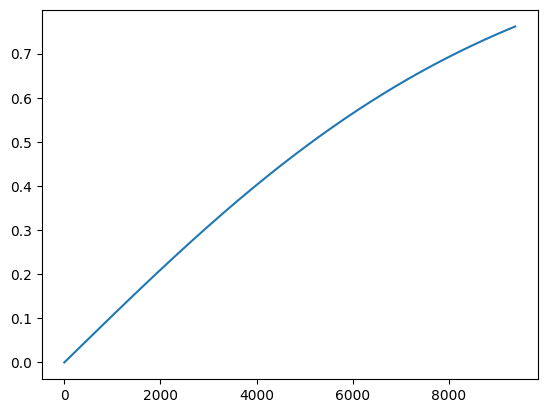

In [20]:
nb_iters = (len(source_train_loader) * epochs)

x = [i for i in range(nb_iters)]
lmbd = lambda e: -1 + 2 / (1 + math.exp(-2 * e / nb_iters))
y = [lmbd(i) for i in x]

plt.plot(x, y)


Let's train our DANN. The GRL factor will be updated after each batch.

Remember that we are not allowed to use the labels of MNIST-M as we assume this dataset is **unlabeled**.

In [21]:
import torch.nn

In [34]:


epochs = 20

dann = DANN().cuda()

optimizer = torch.optim.SGD(dann.parameters(), lr=1.0, momentum=0.9)

mu0, alpha, beta = 0.01, 10, 0.75
scheduler = torch.optim.lr_scheduler.LambdaLR(
    optimizer,
    lambda e: 0.01 / (1 + alpha * e / epochs) ** beta
)
lmbd = lambda e: -1 + 2 / (1 + math.exp(-2 * e / (len(source_train_loader) * epochs)))

b = 0
for epoch in range(epochs):
  cls_loss, domain_loss = 0., 0.
  grl_factor = lmbd(b)
  print(f"GRL factor {grl_factor}" )

  for (xs, ys), (xt, _) in zip(source_train_loader, target_train_loader):
    grl_factor = lmbd(b)
    b += 1

    xs, ys = xs.cuda(), ys.cuda()
    xt = xt.cuda()
    x = torch.cat((xs, xt))

    optimizer.zero_grad()
    cls_logits, domain_logits = dann(x, factor=grl_factor)

    ns=xs.size()[0]
    ce = nn.CrossEntropyLoss()(cls_logits[:ns,:],ys)

    nt=xt.size()[0]
    y_domain=torch.cat(( torch.zeros((ns,1)),torch.ones(nt,1) ) ,dim=0).cuda()
    bce = nn.BCELoss()(domain_logits,y_domain)

    loss = ce + bce
    loss.backward()
    optimizer.step()

    cls_loss += ce.item()
    domain_loss += bce.item()

  cls_loss = round(cls_loss / len(source_train_loader), 5)
  domain_loss = round(domain_loss / (2 * len(source_train_loader)), 5)
  print(f'Epoch {epoch}, class loss: {cls_loss}, domain loss: {domain_loss}')
  scheduler.step()

c_acc, d_acc, c_loss, d_loss = eval_dann(dann, source_test_loader)
print(f"[SOURCE] Class loss/acc: {c_loss} / {c_acc}%, Domain loss/acc: {d_loss} / {d_acc}%")

c_acc, d_acc, c_loss, d_loss = eval_dann(dann, target_test_loader, source=False)
print(f"[TARGET] Class loss/acc: {c_loss} / {c_acc}%, Domain loss/acc: {d_loss} / {d_acc}%")

GRL factor 0.0
Epoch 0, class loss: 0.25527, domain loss: 0.0675
GRL factor 0.049958374957880025
Epoch 1, class loss: 0.04829, domain loss: 0.05865
GRL factor 0.0996679946249559
Epoch 2, class loss: 0.03061, domain loss: 0.07806
GRL factor 0.14888503362331806
Epoch 3, class loss: 0.02472, domain loss: 0.09334
GRL factor 0.197375320224904
Epoch 4, class loss: 0.02359, domain loss: 0.11119
GRL factor 0.2449186624037092
Epoch 5, class loss: 0.02676, domain loss: 0.13381
GRL factor 0.2913126124515908
Epoch 6, class loss: 0.03147, domain loss: 0.16081
GRL factor 0.3363755443363323
Epoch 7, class loss: 0.04962, domain loss: 0.20512
GRL factor 0.379948962255225
Epoch 8, class loss: 0.04316, domain loss: 0.21992
GRL factor 0.4218990052500078
Epoch 9, class loss: 0.04203, domain loss: 0.23927
GRL factor 0.4621171572600098
Epoch 10, class loss: 0.04136, domain loss: 0.26036
GRL factor 0.5005202111902354
Epoch 11, class loss: 0.03336, domain loss: 0.26779
GRL factor 0.5370495669980351
Epoch 12, c

We should see a huge gain, from the ~55% of accuracy on MNIST-M to more than 73% of accuracy without ever seeing labels of MNIST-M.

This is a very nice gain. Let's now verify visualy that our features space is indeed agnostic to the domain:

In [35]:
def extract_emb(net, loader):
  embeddings = []

  for x, _ in loader:
    with torch.no_grad():
      feats = net.cnn(x.cuda()).view(len(x), -1).cpu()

    embeddings.append(feats.numpy())

  return np.concatenate(embeddings)

We use **TSNE** to visualize the embeddings. As you can guess, a human cannot comprehend a space of hundred of dimensions, thus TSNE can project this space onto a space of 2 dimensions.

But beware of the several drawbacks of TSNE:
- **it is super slow**, so we will compute it on a subset of the data
- **it is not determinist**, so you can have different results everytime
- **it can be tuned**, and as everything that can be tuned, you can "*force*" it to take some aspect that you wish it has, while not being really representative of the real data

If you want to learn more about TSNE, head off to this fantastic website: https://distill.pub/2016/misread-tsne/

In [24]:
from sklearn.manifold import TSNE

Original embeddings of source / target (60000, 2352) (60000, 2352)
Samples embeddings (2000, 2352) (2000,)
Dimension reduced embeddings (2000, 2)


Text(0.5, 1.0, 'Without domain adaptation')

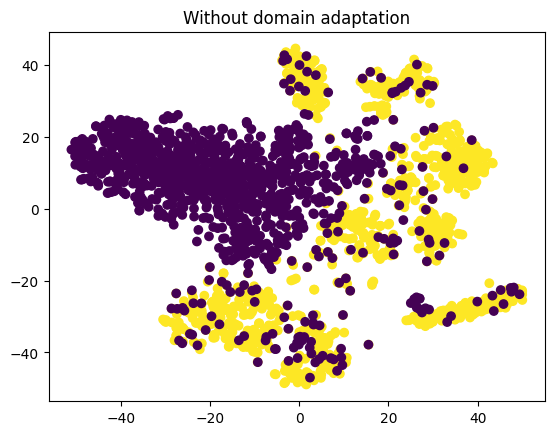

In [36]:
source_emb = extract_emb(naive_net, source_train_loader)
target_emb = extract_emb(naive_net, target_train_loader)

print("Original embeddings of source / target", source_emb.shape, target_emb.shape)

indexes = np.random.permutation(len(source_emb))[:1000]

emb = np.concatenate((source_emb[indexes], target_emb[indexes]))
domains = np.concatenate((np.ones((1000,)), np.zeros((1000,))))

print("Samples embeddings", emb.shape, domains.shape)

tsne = TSNE(n_components=2)

emb_2d = tsne.fit_transform(emb)
print("Dimension reduced embeddings", emb_2d.shape)

plt.scatter(emb_2d[:, 0], emb_2d[:, 1], c=domains)
plt.title("Without domain adaptation")

Yellow dots are the source (MNIST) dataset, while purple dots are the target dataset (MNIST-M). We can clearly see that they belong to different space if we use the naive model.

Original embeddings of source / target (60000, 2352) (60000, 2352)
Samples embeddings (2000, 2352) (2000,)
Dimension reduced embeddings (2000, 2)


Text(0.5, 1.0, 'With domain adaptation')

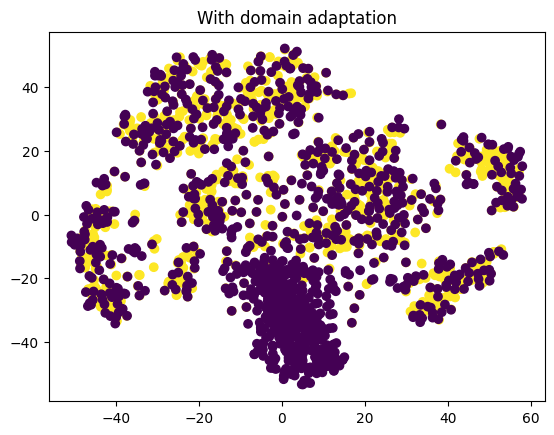

In [37]:
source_emb = extract_emb(dann, source_train_loader)
target_emb = extract_emb(dann, target_train_loader)

print("Original embeddings of source / target", source_emb.shape, target_emb.shape)

indexes = np.random.permutation(len(source_emb))[:1000]

emb = np.concatenate((source_emb[indexes], target_emb[indexes]))
domains = np.concatenate((np.ones((1000,)), np.zeros((1000,))))

print("Samples embeddings", emb.shape, domains.shape)

tsne = TSNE(n_components=2)

emb_2d = tsne.fit_transform(emb)
print("Dimension reduced embeddings", emb_2d.shape)

plt.scatter(emb_2d[:, 0], emb_2d[:, 1], c=domains)
plt.title("With domain adaptation")

But with our DANN, while still imperfect, the two domains are much more merged. This confirm our intuition that the GRL forces the network to produce domain-agnostic features.

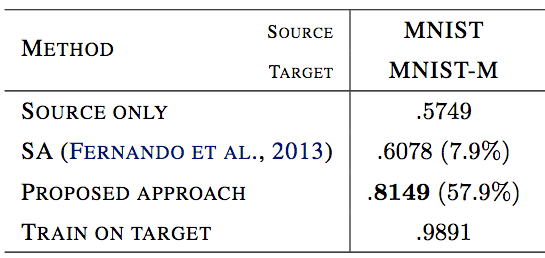

Our model is still lower than the performance reported in the original paper. You can try to further improve it by:

- use much more epochs
- modify the learning rate scheduler to be updated per step
- test different standardization
- different GRL factor scheduling

#### more epochs

In [31]:

def function(net,epochs,mu0=0.01, alpha=10, beta=.75):

  dann = net.cuda()

  optimizer = torch.optim.SGD(net.parameters(), lr=1.0, momentum=0.9)

  scheduler = torch.optim.lr_scheduler.LambdaLR(
      optimizer,
      lambda e: 0.01 / (1 + alpha * e / epochs) ** beta
  )
  lmbd = lambda e: -1 + 2 / (1 + math.exp(-2 * e / (len(source_train_loader) * epochs)))

  b = 0
  for epoch in range(epochs):
    cls_loss, domain_loss = 0., 0.
    grl_factor = lmbd(b)
    print(f"GRL factor {grl_factor}" )

    for (xs, ys), (xt, _) in zip(source_train_loader, target_train_loader):
      grl_factor = lmbd(b)
      b += 1

      xs, ys = xs.cuda(), ys.cuda()
      xt = xt.cuda()
      x = torch.cat((xs, xt))

      optimizer.zero_grad()
      cls_logits, domain_logits = net(x, factor=grl_factor)

      ns=xs.size()[0]
      ce = nn.CrossEntropyLoss()(cls_logits[:ns,:],ys)

      nt=xt.size()[0]
      y_domain=torch.cat(( torch.zeros((ns,1)),torch.ones(nt,1) ) ,dim=0).cuda()
      bce = nn.BCELoss()(domain_logits,y_domain)

      loss = ce + bce
      loss.backward()
      optimizer.step()

      cls_loss += ce.item()
      domain_loss += bce.item()

    cls_loss = round(cls_loss / len(source_train_loader), 5)
    domain_loss = round(domain_loss / (2 * len(source_train_loader)), 5)
    print(f'Epoch {epoch}, class loss: {cls_loss}, domain loss: {domain_loss}')
    scheduler.step()

  c_acc, d_acc, c_loss, d_loss = eval_dann(net, source_test_loader)
  print(f"[SOURCE] Class loss/acc: {c_loss} / {c_acc}%, Domain loss/acc: {d_loss} / {d_acc}%")

  c_acc, d_acc, c_loss, d_loss = eval_dann(net, target_test_loader, source=False)
  print(f"[TARGET] Class loss/acc: {c_loss} / {c_acc}%, Domain loss/acc: {d_loss} / {d_acc}%")

In [32]:
net50=DANN()
function(net50,50)

GRL factor 0.0
Epoch 0, class loss: 0.2382, domain loss: 0.0359
GRL factor 0.01999733375993107
Epoch 1, class loss: 0.05146, domain loss: 0.02067
GRL factor 0.039978680311163695
Epoch 2, class loss: 0.03114, domain loss: 0.04493
GRL factor 0.05992810352914346
Epoch 3, class loss: 0.02211, domain loss: 0.05626
GRL factor 0.07982976911113138
Epoch 4, class loss: 0.0162, domain loss: 0.06143
GRL factor 0.0996679946249559
Epoch 5, class loss: 0.0129, domain loss: 0.06736
GRL factor 0.11942729853438583
Epoch 6, class loss: 0.01075, domain loss: 0.07283
GRL factor 0.1390924478784581
Epoch 7, class loss: 0.01001, domain loss: 0.08026
GRL factor 0.158648504297499
Epoch 8, class loss: 0.00928, domain loss: 0.08849
GRL factor 0.17808086811733026
Epoch 9, class loss: 0.01153, domain loss: 0.10958
GRL factor 0.197375320224904
Epoch 10, class loss: 0.01656, domain loss: 0.12733
GRL factor 0.21651806149302866
Epoch 11, class loss: 0.021, domain loss: 0.14864
GRL factor 0.23549574953849794
Epoch 12, 

Original embeddings of source / target (60000, 2352) (60000, 2352)
Samples embeddings (2000, 2352) (2000,)
Dimension reduced embeddings (2000, 2)


Text(0.5, 1.0, 'With domain adaptation')

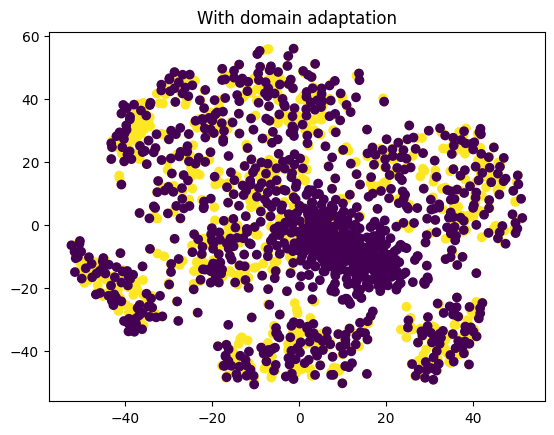

In [38]:
source_emb = extract_emb(net50, source_train_loader)
target_emb = extract_emb(net50, target_train_loader)

print("Original embeddings of source / target", source_emb.shape, target_emb.shape)

indexes = np.random.permutation(len(source_emb))[:1000]

emb = np.concatenate((source_emb[indexes], target_emb[indexes]))
domains = np.concatenate((np.ones((1000,)), np.zeros((1000,))))

print("Samples embeddings", emb.shape, domains.shape)

tsne = TSNE(n_components=2)

emb_2d = tsne.fit_transform(emb)
print("Dimension reduced embeddings", emb_2d.shape)

plt.scatter(emb_2d[:, 0], emb_2d[:, 1], c=domains)
plt.title("With domain adaptation")

#### modify the learning rate scheduler to be updated per step

In [40]:
def function(net, epochs, mu0=0.01, alpha=10, beta=.75):
    dann = net.cuda()

    optimizer = torch.optim.SGD(net.parameters(), lr=1.0, momentum=0.9)

    total_steps = epochs * len(source_train_loader)
    step_lr_lambda = lambda step: mu0 / (1 + alpha * step / total_steps) ** beta

    b = 0
    for epoch in range(epochs):
        cls_loss, domain_loss = 0., 0.

        for (xs, ys), (xt, _) in zip(source_train_loader, target_train_loader):
            grl_factor = lmbd(b)
            b += 1

            # Update learning rate per step
            lr = step_lr_lambda(b)
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr

            xs, ys = xs.cuda(), ys.cuda()
            xt = xt.cuda()
            x = torch.cat((xs, xt))

            optimizer.zero_grad()
            cls_logits, domain_logits = net(x, factor=grl_factor)

            ns = xs.size()[0]
            ce = nn.CrossEntropyLoss()(cls_logits[:ns, :], ys)

            nt = xt.size()[0]
            y_domain = torch.cat((torch.zeros((ns, 1)), torch.ones(nt, 1)), dim=0).cuda()
            bce = nn.BCELoss()(domain_logits, y_domain)

            loss = ce + bce
            loss.backward()
            optimizer.step()

            cls_loss += ce.item()
            domain_loss += bce.item()

        cls_loss = round(cls_loss / len(source_train_loader), 5)
        domain_loss = round(domain_loss / (2 * len(source_train_loader)), 5)
        print(f'Epoch {epoch}, class loss: {cls_loss}, domain loss: {domain_loss}')

    c_acc, d_acc, c_loss, d_loss = eval_dann(net, source_test_loader)
    print(f"[SOURCE] Class loss/acc: {c_loss} / {c_acc}%, Domain loss/acc: {d_loss} / {d_acc}%")

    c_acc, d_acc, c_loss, d_loss = eval_dann(net, target_test_loader, source=False)
    print(f"[TARGET] Class loss/acc: {c_loss} / {c_acc}%, Domain loss/acc: {d_loss} / {d_acc}%")


In [41]:
net20_step=DANN()
function(net20_step,20)

Epoch 0, class loss: 0.2529, domain loss: 0.05115
Epoch 1, class loss: 0.05307, domain loss: 0.03702
Epoch 2, class loss: 0.03606, domain loss: 0.07815
Epoch 3, class loss: 0.02794, domain loss: 0.09768
Epoch 4, class loss: 0.02497, domain loss: 0.11569
Epoch 5, class loss: 0.0279, domain loss: 0.13268
Epoch 6, class loss: 0.03469, domain loss: 0.15704
Epoch 7, class loss: 0.03467, domain loss: 0.18556
Epoch 8, class loss: 0.04681, domain loss: 0.22718
Epoch 9, class loss: 0.04501, domain loss: 0.2526
Epoch 10, class loss: 0.05527, domain loss: 0.25741
Epoch 11, class loss: 0.03386, domain loss: 0.26118
Epoch 12, class loss: 0.02817, domain loss: 0.26045
Epoch 13, class loss: 0.02712, domain loss: 0.26739
Epoch 14, class loss: 0.02511, domain loss: 0.26404
Epoch 15, class loss: 0.02596, domain loss: 0.26805
Epoch 16, class loss: 0.02654, domain loss: 0.27809
Epoch 17, class loss: 0.02383, domain loss: 0.28058
Epoch 18, class loss: 0.02397, domain loss: 0.27935
Epoch 19, class loss: 0.0

Original embeddings of source / target (60000, 2352) (60000, 2352)
Samples embeddings (2000, 2352) (2000,)
Dimension reduced embeddings (2000, 2)


Text(0.5, 1.0, 'With domain adaptation')

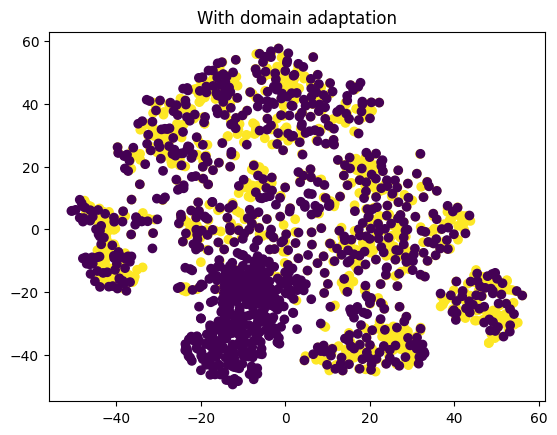

In [42]:
source_emb = extract_emb(net20_step, source_train_loader)
target_emb = extract_emb(net20_step, target_train_loader)

print("Original embeddings of source / target", source_emb.shape, target_emb.shape)

indexes = np.random.permutation(len(source_emb))[:1000]

emb = np.concatenate((source_emb[indexes], target_emb[indexes]))
domains = np.concatenate((np.ones((1000,)), np.zeros((1000,))))

print("Samples embeddings", emb.shape, domains.shape)

tsne = TSNE(n_components=2)

emb_2d = tsne.fit_transform(emb)
print("Dimension reduced embeddings", emb_2d.shape)

plt.scatter(emb_2d[:, 0], emb_2d[:, 1], c=domains)
plt.title("With domain adaptation")

In [43]:
net50_step=DANN()
function(net50_step,50)

Epoch 0, class loss: 0.22751, domain loss: 0.04407
Epoch 1, class loss: 0.05172, domain loss: 0.06254
Epoch 2, class loss: 0.03287, domain loss: 0.08417
Epoch 3, class loss: 0.02645, domain loss: 0.09604
Epoch 4, class loss: 0.0403, domain loss: 0.1085
Epoch 5, class loss: 0.02493, domain loss: 0.11747
Epoch 6, class loss: 0.03081, domain loss: 0.15802
Epoch 7, class loss: 0.054, domain loss: 0.22188
Epoch 8, class loss: 0.12792, domain loss: 1.29769
Epoch 9, class loss: 0.04451, domain loss: 0.20958
Epoch 10, class loss: 0.03509, domain loss: 0.27172
Epoch 11, class loss: 0.02799, domain loss: 0.25195
Epoch 12, class loss: 0.02457, domain loss: 0.25359
Epoch 13, class loss: 0.02339, domain loss: 0.26138
Epoch 14, class loss: 0.02323, domain loss: 0.26991
Epoch 15, class loss: 0.02948, domain loss: 0.28714
Epoch 16, class loss: 0.03155, domain loss: 0.29106
Epoch 17, class loss: 0.03174, domain loss: 0.29759
Epoch 18, class loss: 0.02455, domain loss: 0.28684
Epoch 19, class loss: 0.04

Original embeddings of source / target (60000, 2352) (60000, 2352)
Samples embeddings (2000, 2352) (2000,)
Dimension reduced embeddings (2000, 2)


Text(0.5, 1.0, 'With domain adaptation')

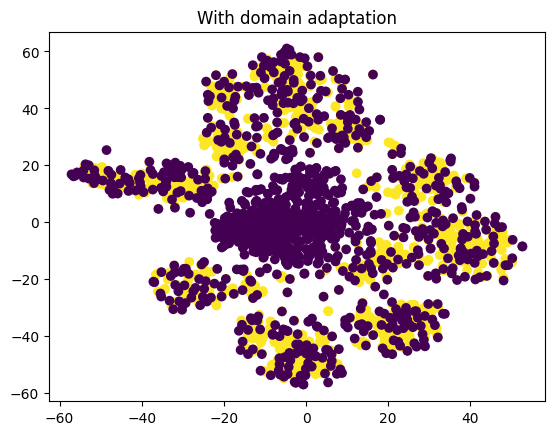

In [44]:
source_emb = extract_emb(net50_step, source_train_loader)
target_emb = extract_emb(net50_step, target_train_loader)

print("Original embeddings of source / target", source_emb.shape, target_emb.shape)

indexes = np.random.permutation(len(source_emb))[:1000]

emb = np.concatenate((source_emb[indexes], target_emb[indexes]))
domains = np.concatenate((np.ones((1000,)), np.zeros((1000,))))

print("Samples embeddings", emb.shape, domains.shape)

tsne = TSNE(n_components=2)

emb_2d = tsne.fit_transform(emb)
print("Dimension reduced embeddings", emb_2d.shape)

plt.scatter(emb_2d[:, 0], emb_2d[:, 1], c=domains)
plt.title("With domain adaptation")

#### normalisation

In [60]:
class DANN_bis(nn.Module):
    def __init__(self):
        super().__init__()  # Important, otherwise will throw an error

        self.cnn = nn.Sequential(
            nn.Conv2d(3, 32, (5, 5), stride=1, padding=2),
            nn.BatchNorm2d(32),  # Batch Normalization layer after convolution
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0),
            nn.Dropout2d(),
            nn.Conv2d(32, 48, (5, 5), stride=1, padding=2),
            nn.BatchNorm2d(48),# Batch Normalization layer after convolution
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0)
        )

        self.classif = nn.Sequential(
            nn.Linear(2352, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(100, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(),
            nn.Linear(100, 10)
        )
        self.domain = nn.Sequential(
            nn.Linear(2352, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(),
            nn.Linear(100, 1)
        )

    def forward(self, x, factor=1):
      bsize = x.size(0) # batch size
      output = self.cnn(x) # output of the conv layers
      output = output.view(bsize, -1) # we flatten the 2D feature maps into one 1D vector for each input

      class_pred = self.classif(output) # we compute the output of the fc layers

      rev_output = GradientReversal.apply(output, -factor)
      domain_pred= self.domain(rev_output)


      return class_pred, domain_pred


In [65]:
net50_norm=DANN_bis()
function(net50_norm,50)

RuntimeError: ignored